In [7]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL
class Caltech256(Dataset):
    '''
    
    Args:
    
        root_dir (string): Location of Caltech256 Dataset,
        images_per_class (int): Number of images to load per class. Class clutter is ignored
        transform (torch.transform): transformation to perform on input image
    
    Example Usage:
    
        example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

        caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
        
        train_data = DataLoader(
            dataset = caltech256_train,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )
        
        
    '''
    def __init__(self, root_dir, transform=None, train = True):
        self.images_per_class = 32 if train else 8
        self.start_image = (~train) * 32
        self.end_image = self.start_image + self.images_per_class
        self.root_dir = root_dir
        self.transform = transform
        self.cats = os.listdir(root_dir)
        self.files = {}
        self.train = train
        for cat in self.cats:
            if "clutter" in cat:
                continue

            currdir = os.path.join(root_dir, cat)
            images = os.listdir(currdir)
            images = list(filter(lambda s: s.endswith("jpg"), images))
            assert self.images_per_class <= len(images), "Not enough images in class {c}".format(c = currdir)
                
            for i in range(self.start_image, self.end_image):
                self.files[os.path.join(currdir, images[i])] = int("".join(images[i][0:3]))
                 
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name, label = list(self.files.items())[idx]
        image = PIL.Image.open(img_name).convert("RGB") # A few images are grayscale
        label = torch.Tensor([label-1])
        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [8]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torchvision.datasets 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# torch.__version__
#import torchsample as ts

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler
torch.cuda.current_device()

from torch.optim import lr_scheduler

In [9]:
def validationSplit(trainset, ratio=0.01, random_seed=42):
    trainlen = len(trainset)
    indices = list(range(trainlen))
    split = int(np.floor(ratio*trainlen))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)    
    return train_sampler, valid_sampler

In [10]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.Scale((224,224)),
     #torchvision.transforms.Scale(size, interpolation=2),
     #torchvision.transforms.CenterCrop(size),
     #torchvision.transforms.RandomCrop(size, padding=0),
     #torchvision.transforms.RandomSizedCrop(32, interpolation=2),
     transforms.ToTensor(),
     #transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

trainset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=True)
testset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=False)
"""
trainloader = DataLoader(
    dataset = caltech256_train,
    batch_size = 128,
    shuffle = True,
    num_workers = 4
)
"""
batch_size=64

train_sampler, valid_sampler = validationSplit(trainset, ratio=0.1, random_seed=47)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True, download=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False, download=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
class VGG_3_probe(nn.Module):
    def __init__(self):
        super(VGG_3_probe, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:-14])
        self.lastlayer = nn.Sequential(nn.Linear(256*28*28, 1024), nn.LeakyReLU(inplace=True), nn.Linear(1024, 256))
        
    def forward(self, x):
        out = self.pretrained(x)
        #print(out.size())
        out = out.view(out.size(0), -1)
        #print(out.size())
        out = self.lastlayer(out)
        return out
    
    def setGrads(self):
        for param in self.pretrained.parameters():
            param.requires_grad = False
        
        for param in self.lastlayer.parameters():
            param.requires_grad = True      
            
    def initWeights(self):
        for m in self.lastlayer.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform(m.weight)

In [13]:
class VGG_4_probe(nn.Module):
    def __init__(self):
        super(VGG_4_probe, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:-7])
        self.lastlayer = nn.Sequential(nn.Linear(512*14*14, 1024), nn.ReLU(inplace=True), nn.Linear(1024, 256))
        
    def forward(self, x):
        out = self.pretrained(x)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())
        out = self.lastlayer(out)
#         print(out.size())
        return out
    
    def setGrads(self):
        for param in self.pretrained.parameters():
            param.requires_grad = False
        
        for param in self.lastlayer.parameters():
            param.requires_grad = True      
            
    def initWeights(self):
        for m in self.lastlayer.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform(m.weight)

In [14]:
class VGG_modified(nn.Module):
    def __init__(self):
        super(VGG_modified, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:])
        self.classifier = nn.Sequential(*list(pretrained_model.classifier.children())[:-1])
        #self.lastlayer = nn.Sequential(nn.Linear(4096, 256), nn.ReLU(inplace=True), nn.Softmax())
        self.lastlayer = nn.Sequential(nn.Linear(4096, 256))
        
    def forward(self, x):
        out = self.pretrained(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        out = self.lastlayer(out)
        return out

    def setGrads(self):
        for param in self.pretrained.parameters():
            param.requires_grad = False
        
        for param in self.classifier.parameters():
            param.requires_grad = False
        
        for param in self.lastlayer.parameters():
            param.requires_grad = True      
            
    def initWeights(self):
        for m in self.lastlayer.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform(m.weight)

In [16]:
class Trainer():
    def __init__(self, modelname, epochs, batchsize, lr, trainloader, validloader, testloader, model, weightdecay):
        self.epochs=epochs
        self.batch_size=batchsize
        self.learning_rate=lr
        self.train_loader=trainloader
        self.valid_loader=validloader
        self.test_loader=testloader
        self.model=model
        self.weight_decay=weightdecay
        self.modelname=modelname
        self.optimizer=torch.optim.Adam(model.lastlayer.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
    
    def getAllStats(model, loaderlist):
        model.eval()
        results={}
        criterion = nn.CrossEntropyLoss()
        for i, loader in zip(range(len(loaderlist)),loaderlist):
            correct = 0
            total = 0
            loss = 0
            results[i]={}
            for images, labels in loader:
                labels = labels.long()
                labels = labels.view(labels.size(0))
                labels = labels.cuda()

                images = Variable(images).cuda()
                outputs = model(images).cuda()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum()

                labels = Variable(labels)
                loss += criterion(outputs, labels).data[0]*images.size(0)
            results[i]['accuracy']=((100 * correct / total))
            results[i]['loss']=((loss / total))
        return results

    def train(self):
        # Hyper Parameters
        num_epochs = self.epochs
        batch_size = self.batch_size
        learning_rate = self.learning_rate
        trainloader=self.train_loader
        validloader=self.valid_loader
        testloader=self.test_loader
        cnn=self.model

        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = self.optimizer

        #scheduler
        from torch.optim import lr_scheduler
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
        pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,\
                                                          patience=3, verbose=True, threshold=0.0001,
                                                          threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
        train_accuracy=[]
        train_loss=[]
        validation_accuracy=[]
        validation_loss=[]
        test_accuracy=[]
        test_loss=[]
        
        # Train the Model
        for epoch in range(num_epochs):
            running_loss = 0.0
            running_corrects = 0
            for i, (images, labels) in enumerate(trainloader):
                images = Variable(images).cuda()
                labels = labels.long()
                labels = labels.view(labels.size(0))
                labels = Variable(labels).cuda()

                optimizer.zero_grad()

                outputs = cnn(images)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.data[0]*images.size(0)
                running_corrects += torch.sum(preds == labels.data)

                loss.backward()
                optimizer.step()

                if (i+1) % 16 == 0:
                    print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                           %(epoch+1, num_epochs, i+1, len(trainset)//batch_size, loss.data[0]))    

            epoch_loss = running_loss / len(trainloader.dataset)
            epoch_acc = running_corrects*100 / len(trainloader.dataset)
            train_accuracy.append(epoch_acc)
            train_loss.append(epoch_loss)

            print("\t\t\t\t\t","training\t", "%3.10f  %3.10f" % (epoch_acc, epoch_loss))

            results=Trainer.getAllStats(cnn, [validloader, testloader])
            namedict={ 0:"validation", 1:"testing"}
            for key,val in results.items():
                if(key==0):
                    validation_accuracy.append(results[key]['accuracy'])
                    validation_loss.append(results[key]['loss'])
                else:
                    test_accuracy.append(results[key]['accuracy'])
                    test_loss.append(results[key]['loss'])
                print("\t\t\t\t\t",namedict[key],"\t", "%3.10f  %3.10f" % (results[key]['accuracy'], results[key]['loss']))

            pla_lr_scheduler.step(validation_loss[-1])
        
        torch.save(cnn.state_dict(), self.modelname)
        self.saveModel(train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss)
        return train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss
    
    def saveModel(self, train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss):
        import pickle
        f = open(self.modelname+"plotdata_final", "wb")
        pickle.dump(train_accuracy, f)
        pickle.dump(train_loss, f)
        pickle.dump(validation_accuracy, f)
        pickle.dump(validation_loss, f)
        pickle.dump(test_accuracy, f)
        pickle.dump(test_loss, f)
        f.close()

In [17]:
cnn3 = VGG_3_probe()
cnn3.setGrads()
cnn3.initWeights()
cnn3=cnn3.cuda()

In [18]:
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_3.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn3,\
        weightdecay=0.0001, epochs=30, batchsize=64, lr=0.001).train()

Epoch [1/30], Iter [16/128] Loss: 839.5021
Epoch [1/30], Iter [32/128] Loss: 353.0151
Epoch [1/30], Iter [48/128] Loss: 131.4409
Epoch [1/30], Iter [64/128] Loss: 80.2752
Epoch [1/30], Iter [80/128] Loss: 37.6826
Epoch [1/30], Iter [96/128] Loss: 25.3318
Epoch [1/30], Iter [112/128] Loss: 20.1501
					 training	 2.1606445312  223.8914202568
					 validation 	 5.7387057387  16.5311203119
					 testing 	 5.3710937500  17.1409235895
Epoch [2/30], Iter [16/128] Loss: 10.2260
Epoch [2/30], Iter [32/128] Loss: 9.0877
Epoch [2/30], Iter [48/128] Loss: 8.9471
Epoch [2/30], Iter [64/128] Loss: 6.9859
Epoch [2/30], Iter [80/128] Loss: 9.3294
Epoch [2/30], Iter [96/128] Loss: 6.7545
Epoch [2/30], Iter [112/128] Loss: 6.2807
					 training	 19.2871093750  7.6676515994
					 validation 	 8.9133089133  10.3713134072
					 testing 	 9.6191406250  10.0725639760
Epoch [3/30], Iter [16/128] Loss: 5.0245
Epoch [3/30], Iter [32/128] Loss: 5.1657
Epoch [3/30], Iter [48/128] Loss: 3.6293
Epoch [3/30], Iter 

Epoch [20/30], Iter [32/128] Loss: 0.0169
Epoch [20/30], Iter [48/128] Loss: 0.0149
Epoch [20/30], Iter [64/128] Loss: 0.1513
Epoch [20/30], Iter [80/128] Loss: 0.0062
Epoch [20/30], Iter [96/128] Loss: 0.0067
Epoch [20/30], Iter [112/128] Loss: 0.0082
					 training	 89.8925781250  0.0235597747
					 validation 	 31.5018315018  4.3383203350
					 testing 	 30.0292968750  4.4496824294
Epoch [21/30], Iter [16/128] Loss: 0.0052
Epoch [21/30], Iter [32/128] Loss: 0.0090
Epoch [21/30], Iter [48/128] Loss: 0.0241
Epoch [21/30], Iter [64/128] Loss: 0.0084
Epoch [21/30], Iter [80/128] Loss: 0.0746
Epoch [21/30], Iter [96/128] Loss: 0.0100
Epoch [21/30], Iter [112/128] Loss: 0.0224
					 training	 89.9658203125  0.0117078861
					 validation 	 31.5018315018  4.2321410494
					 testing 	 30.2246093750  4.3838692755
Epoch [22/30], Iter [16/128] Loss: 0.0121
Epoch [22/30], Iter [32/128] Loss: 0.0647
Epoch [22/30], Iter [48/128] Loss: 0.0098
Epoch [22/30], Iter [64/128] Loss: 0.0116
Epoch [22/30],

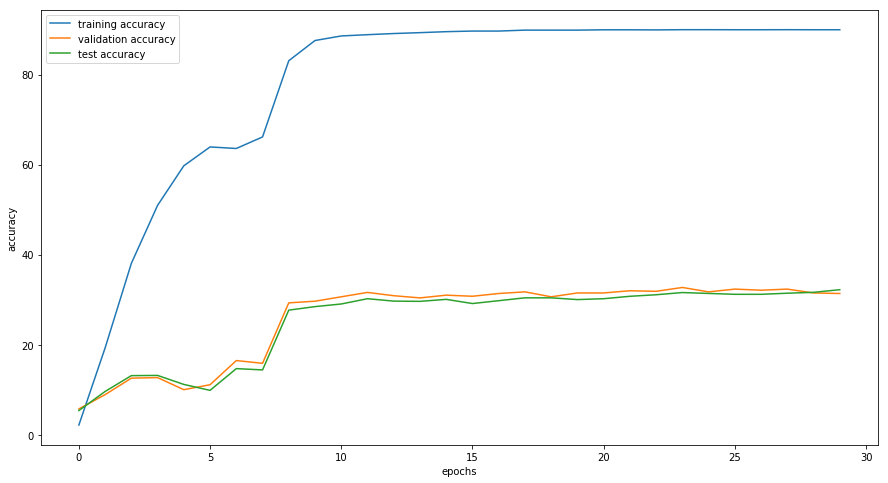

In [19]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

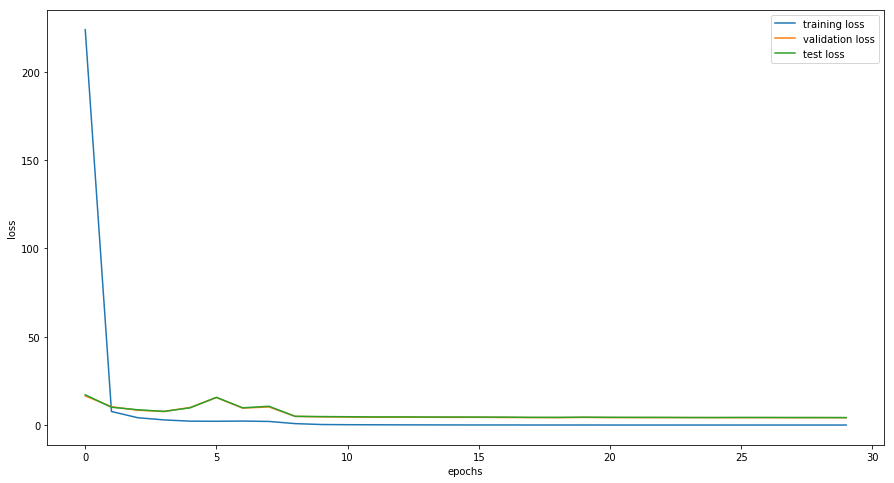

In [22]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [37]:
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_3.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn3,\
        weightdecay=0.0001, epochs=20, batchsize=64, lr=0.001).train()

Epoch [1/20], Iter [16/128] Loss: 903.7141
Epoch [1/20], Iter [32/128] Loss: 382.5823
Epoch [1/20], Iter [48/128] Loss: 150.1072
Epoch [1/20], Iter [64/128] Loss: 65.2195
Epoch [1/20], Iter [80/128] Loss: 38.8999
Epoch [1/20], Iter [96/128] Loss: 32.7402
Epoch [1/20], Iter [112/128] Loss: 21.2843
					 training	 1.8920898438  247.3746449265
					 validation 	 6.4713064713  17.7890625559
					 testing 	 6.3476562500  17.1828517914
Epoch [2/20], Iter [16/128] Loss: 12.6363
Epoch [2/20], Iter [32/128] Loss: 7.6518
Epoch [2/20], Iter [48/128] Loss: 7.4978
Epoch [2/20], Iter [64/128] Loss: 6.1946
Epoch [2/20], Iter [80/128] Loss: 6.5246
Epoch [2/20], Iter [96/128] Loss: 5.9607
Epoch [2/20], Iter [112/128] Loss: 6.4100
					 training	 20.8251953125  7.5778696485
					 validation 	 8.3028083028  8.4069142790
					 testing 	 10.8886718750  8.1777452528
Epoch [3/20], Iter [16/128] Loss: 4.3277
Epoch [3/20], Iter [32/128] Loss: 3.9422
Epoch [3/20], Iter [48/128] Loss: 3.4585
Epoch [3/20], Iter [

Epoch [20/20], Iter [32/128] Loss: 0.0077
Epoch [20/20], Iter [48/128] Loss: 0.0206
Epoch [20/20], Iter [64/128] Loss: 0.0187
Epoch [20/20], Iter [80/128] Loss: 0.0071
Epoch [20/20], Iter [96/128] Loss: 0.0049
Epoch [20/20], Iter [112/128] Loss: 0.0090
					 training	 89.9902343750  0.0109383455
					 validation 	 33.2112332112  3.5406543792
					 testing 	 32.7636718750  3.6832403317


In [1]:
import pickle
file = open("VGG_3.pklplotdata",'rb')
plots = pickle.load(file)
file.close()

In [6]:
import pickle
file = "VGG_3.pklplotdata"
with open(file, "rb") as f:
    print (pickle.load(f))
f.close()

[1.89208984375, 20.8251953125, 40.625, 53.62548828125, 63.18359375, 66.0888671875, 70.17822265625, 69.9462890625, 67.83447265625, 81.0546875, 88.07373046875, 88.70849609375, 89.09912109375, 89.46533203125, 89.58740234375, 89.80712890625, 89.78271484375, 89.9169921875, 89.94140625, 89.990234375]


In [23]:
# pretrained_model = torchvision.models.vgg16(pretrained=True)
# list(pretrained_model.classifier.children())[:]
# print(cnn)

In [ ]:
cnn4 = VGG_4_probe()
cnn4.setGrads()
cnn4.initWeights()
cnn4=cnn4.cuda()

In [ ]:
train_accuracy, train_loss, validation_accuracy, validation_loss, test_accuracy, test_loss = \
Trainer(modelname="VGG_4.pkl",trainloader=trainloader, validloader=validloader, testloader=testloader, model=cnn4,\
        weightdecay=0.0001, epochs=20, batchsize=64, lr=0.001).train()

Epoch [1/20], Iter [16/128] Loss: 44.3817
Epoch [1/20], Iter [32/128] Loss: 5.2469
Epoch [1/20], Iter [48/128] Loss: 5.3657
Epoch [1/20], Iter [64/128] Loss: 5.6999
Epoch [1/20], Iter [80/128] Loss: 5.3808
Epoch [1/20], Iter [96/128] Loss: 5.3764
Epoch [1/20], Iter [112/128] Loss: 5.3339
					 training	 2.8442382812  13.3483811878
					 validation 	 4.3956043956  5.2634406672
					 testing 	 4.2968750000  5.2997518927
Epoch [2/20], Iter [16/128] Loss: 5.2709
Epoch [2/20], Iter [32/128] Loss: 5.0443
Epoch [2/20], Iter [48/128] Loss: 5.0862
Epoch [2/20], Iter [64/128] Loss: 4.9367
Epoch [2/20], Iter [80/128] Loss: 4.8328
Epoch [2/20], Iter [96/128] Loss: 4.5950
Epoch [2/20], Iter [112/128] Loss: 4.2870
					 training	 9.3383789062  4.3931676493
					 validation 	 10.1343101343  4.9887127411
					 testing 	 10.4492187500  5.0263858140
Epoch [3/20], Iter [16/128] Loss: 4.0565
Epoch [3/20], Iter [32/128] Loss: 5.0144
Epoch [3/20], Iter [48/128] Loss: 4.5597
Epoch [3/20], Iter [64/128] Loss:

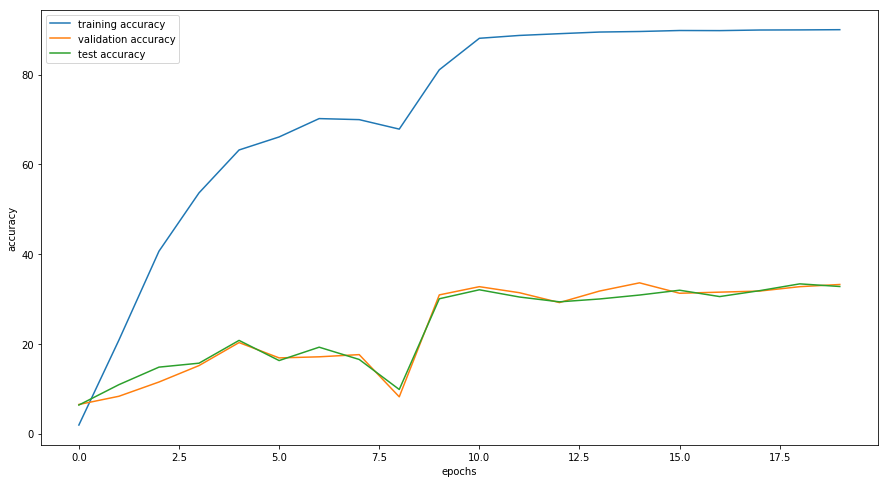

In [38]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()